### Import packages and define the namespace for the GPX schema

If you get an error here, you will have to add packages to your Python distribution

In [2]:
import os, string, copy, sys, subprocess
import shutil
import datetime as datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lxml import etree
from scipy.interpolate import interp1d
from PIL import Image, ExifTags
import mplleaflet
import ipyleaflet as ipyl

%matplotlib inline

## Input Variables 

In [3]:
# unique to local files:

homedir = r'/Volumes/stor/Projects/UAS_SfM/EROS_plumisland_test/test1'
logfile = r'/Volumes/stor/Projects/UAS_SfM/EROS_plumisland_test/test1/tlogs/f6.gpx'
imagefolder = r'/Volumes/stor/Projects/UAS_SfM/EROS_plumisland_test/test1/images/f6'

# homedir = '/Data/2018_PlumIsland/2018_015_FA_PlumIs_Feb/test_script/ricoh'
# homedir = input("Which directory contains your raw images and telemetry data (e.g. {})? ".format(homedir))

flight = 'f6'
# flight = input("Which flight? Must match folder name in tlogs folder (e.g. f6). ")
logfile = os.path.join(homedir,'tlogs/', flight+'.gpx')
imagefolder = os.path.join(homedir,'images/', flight)

navcsvoutfile = os.path.splitext(logfile)[0]+'_gpx.csv'
imgoutdir = imagefolder+'_new/'
print("input nav file is: {}\noutput nav file is: {}\nworking JPEG dir is: {}\nprocessed JPEG dir is: {}".format(logfile, navcsvoutfile, imagefolder, imgoutdir))

# Mission info - would be nice for logfile and image folder names to correspond to naming convention, as below

## use first line to hardcode the FA #, use next line to prompt for it
fan = '2018-015-FA' # raw_input('Field activity number (e.g. "2017-010-FA"): ')
surveyid = fan
#fan = input("What is the field activity identifier (e.g. 2018-015-FA)? ")
#uas_id = 'u045' # raw_input('U-number of mission (e.g. "u031"): ')

#fc_id = 'f06r01' # raw_input('Flight number (e.g. "04"): ') raw_input('Camera code (e.g. "r01"): ')
fc_id = 'r01' # raw_input('Flight number (e.g. "04"): ') raw_input('Camera code (e.g. "r01"): ')
#fc_id = input("What is the sensor identifier (e.g. r01)? ") 
    
# WHSC EXIF population
credit = "U.S. Geological Survey"
comment = "Low-altitude aerial photograph of Plum Island, MA from survey {} (https://cmgds.marine.usgs.gov/fan_info.php?fa={}).".format(fan, fan)
keywords = "Plum Island, Massachusetts, {}, UAS, nadir, USGS".format(fan)

# Standard values:
namespace = {'def': 'http://www.topografix.com/GPX/1/1'}
tfmt_exif = '%Y:%m:%d %H:%M:%S' #e.g. 2017-05-04 14:14:12
tfmt_gpx = '%Y-%m-%dT%H:%M:%S' #e.g. 2017-05-04T14:14:12-04:00
iso_fmt="%Y%m%dT%H%M%SZ"
survey_id = fan.replace("-","")

input nav file is: /Volumes/stor/Projects/UAS_SfM/EROS_plumisland_test/test1/tlogs/f6.gpx
output nav file is: /Volumes/stor/Projects/UAS_SfM/EROS_plumisland_test/test1/tlogs/f6_gpx.csv
working JPEG dir is: /Volumes/stor/Projects/UAS_SfM/EROS_plumisland_test/test1/images/f6
processed JPEG dir is: /Volumes/stor/Projects/UAS_SfM/EROS_plumisland_test/test1/images/f6_new/


### Verify the user input data looks right before continuing

In [4]:
input_check = "FA = {}    flight = {}    sensor = {}".format(fan, flight, fc_id)
print ("input data: "+ input_check)

while True:
   answer = input('Does the input data above look right?:')
   if answer.lower().startswith("y"):
        break
   elif answer.lower().startswith("n"):
      print("ok, try to re-run the script and enter the correct FA, flight and sensor")
      sys.exit()

if not os.path.isfile(logfile):
    print("We don't see the specified file: {}".format(logfile))
    sys.exit()
else:
    print("Great!! Looks like the logfile is present as well. Carry on.")
    
# print("Great!! Carry on")

input data: FA = 2018-015-FA    flight = f6    sensor = r01
Does the input data above look right?:y
Great!! Looks like the logfile is present as well. Carry on.


## Functions

In [5]:
def gpx_tag_to_pdseries(tree, namespace, tag):
    elist = tree.xpath('./def:trk//def:trkpt//def:'+tag, namespaces=namespace)
    ser = pd.Series([e.text for e in elist], name=tag)
    return(ser)

def write_WHSC_exiftags(imgdir, credit, comment, keywords):
    # Tags that will be identical for all images in the folder
    tagvalues = {}
    tagvalues['imgdir'] = imagefolder
    tagvalues['credit'] = credit
    tagvalues['artist'] = "AIM Group"
    tagvalues['contact'] = "WHSC_data_contact@usgs.gov"
    tagvalues['comment'] = comment
    tagvalues['keywords'] = keywords
    tagvalues['copyright'] = "Public Domain. Please credit {credit}".format(**tagvalues)
    # Write to EXIF
    cmd = """exiftool -Artist="{artist} " -Credit="{credit} " -Contact="{contact} " -comment="{comment} " -sep ", " -keywords="{keywords} " -Caption="{comment} " -Copyright="{copyright} " -CopyrightNotice="{copyright} " -Caption-Abstract="{comment} " -ImageDescription="{comment} " {imgdir}""".format(**tagvalues)
    subprocess.check_call(cmd, shell=True)
    return(True)

## Parse GPX file

In [7]:
# Parse GPX and extract components into dataframe
tree = etree.parse(logfile)

# latitude and longitude
elist = tree.xpath('./def:trk//def:trkpt',namespaces=namespace)
gpxdf = pd.DataFrame([e.values() for e in elist], columns=['lat', 'lon']).apply(pd.to_numeric)

# all tags (inc time)
taglist = ['time', 'ele', 'ele2', 'course', 'roll', 'pitch', 'mode']
for tag in taglist:
    gpxdf = gpxdf.join(pd.to_numeric(gpx_tag_to_pdseries(tree, namespace, tag), errors='ignore'))

# Check number of records and number of unique times 
print ("number of records: ", len(gpxdf.index))
print ("number of unique times: {}\n".format(len(gpxdf.time.unique())))

gpxdf.head()

number of records:  6565
number of unique times: 925



lat        lon                       time   ele  ele2    course  \
0  42.772645 -70.805902  2018-02-27T19:10:13+00:00  9.63 -0.37  320.8459   
1  42.772645 -70.805902  2018-02-27T19:10:13+00:00  9.67 -0.33  320.8288   
2  42.772645 -70.805902  2018-02-27T19:10:13+00:00  9.73 -0.27  320.8474   
3  42.772645 -70.805902  2018-02-27T19:10:14+00:00  9.85 -0.15  320.9413   
4  42.772645 -70.805902  2018-02-27T19:10:14+00:00  9.88 -0.12  320.9644   

       roll     pitch    mode  
0  0.649377  0.709408  Loiter  
1  0.644466  0.751076  Loiter  
2  0.616625  0.811612  Loiter  
3  0.562210  0.906102  Loiter  
4  0.557802  0.921579  Loiter

### Add datetime field to gpxdf dataframe

Convert the time field to: 

- datetime_utc: datetime in UTC
- epoch_utc: Unix epoch time, which counts seconds from January 1, 1970

In [9]:
# Standard values:
namespace = {'def': 'http://www.topografix.com/GPX/1/1'}
tfmt_exif = '%Y:%m:%d %H:%M:%S' #e.g. 2017-05-04 14:14:12
tfmt_gpx = '%Y-%m-%dT%H:%M:%S' #e.g. 2017-05-04T14:14:12-04:00
iso_fmt="%Y%m%dT%H%M%SZ"

# Convert values in 'time' field to datetime UTC and convert datetime UTC to Epoch UTC
gpxdf['datetime_utc'] = pd.to_datetime(gpxdf['time'], format = tfmt_gpx)
gpxdf['epoch_utc'] = gpxdf['datetime_utc'].astype(np.int64) // 10**9

## this applies the local time zone offset to create a UTC epochtime value
## March 2018 - commented out the tzoffset part for Plum Island survey - collected in UTC
# gpxdf['epoch_utc'] = gpxdf['epoch_utc'].astype(str).astype(int) 
gpxdf.head()

lat        lon                       time   ele  ele2    course  \
0  42.772645 -70.805902  2018-02-27T19:10:13+00:00  9.63 -0.37  320.8459   
1  42.772645 -70.805902  2018-02-27T19:10:13+00:00  9.67 -0.33  320.8288   
2  42.772645 -70.805902  2018-02-27T19:10:13+00:00  9.73 -0.27  320.8474   
3  42.772645 -70.805902  2018-02-27T19:10:14+00:00  9.85 -0.15  320.9413   
4  42.772645 -70.805902  2018-02-27T19:10:14+00:00  9.88 -0.12  320.9644   

       roll     pitch    mode        datetime_utc   epoch_utc  
0  0.649377  0.709408  Loiter 2018-02-27 19:10:13  1519758613  
1  0.644466  0.751076  Loiter 2018-02-27 19:10:13  1519758613  
2  0.616625  0.811612  Loiter 2018-02-27 19:10:13  1519758613  
3  0.562210  0.906102  Loiter 2018-02-27 19:10:14  1519758614  
4  0.557802  0.921579  Loiter 2018-02-27 19:10:14  1519758614

### Export (csv) and plot (png) the GPX data

Exported output CSV file called: /Volumes/stor/Projects/UAS_SfM/EROS_plumisland_test/test1/tlogs/f6_gpx.csv 



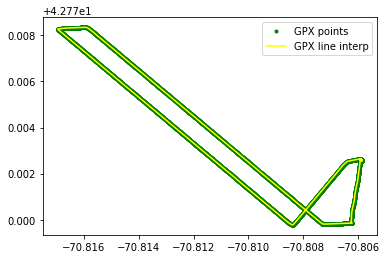

In [12]:
# Export CSV
gpxdf.to_csv(navcsvoutfile, index=False)
print ("Exported output CSV file called:", navcsvoutfile,"\n")

# Plot the flight path
fig = plt.figure()
plt.plot(gpxdf.lon,gpxdf.lat,'.', c='green', label="GPX points")
ax = fig.add_subplot(111)
# how is this interpolated? Does simply indicate '-' tell it to plot as a line, which includes interpolation? 
ax.plot(gpxdf.lon,gpxdf.lat,'-', c='yellow', label="GPX line interp")
ax.legend()
#plt.show()
fig.savefig(os.path.join(homedir, "{}_gpxtrack.png".format(os.path.splitext(logfile)[0])))
#fig.clear()

### Plot GPX on basemap using Leaflet

In [13]:
# Plot it on a map using Leaflet and aerial photo background
## need to figure out a way to cache the map layer or load a geotiff so we can do this offline

fig = plt.figure()
plt.plot(gpxdf.lon,gpxdf.lat,'.', c='green')
ax = fig.add_subplot(111)
ax.plot(gpxdf.lon,gpxdf.lat,'-', c='yellow')

mplleaflet.show(tiles='esri_aerial')
print ("Printing map for {} in new window".format(fc_id))

## this will copy the temp leaflet html map to the tlog folder and name it the appropriate flight 
## need to figure out how to save as PNG file instead (html to png??)
os.system("cp ./_map.html " + homedir + "/tlogs/" + flight + "_map.html")

Printing map for r01 in new window


0

In [32]:
# Basemap: Esri WorldImagery

# get map center at middle of data bounds
center = [np.mean([float(max(gpxdf.lat)), float(min(gpxdf.lat))]), 
          np.mean([float(max(gpxdf.lon)), float(min(gpxdf.lon))])]
center = [np.mean([max(gpxdf.lat), min(gpxdf.lat)]), 
          np.mean([max(gpxdf.lon), min(gpxdf.lon)])]
zoom = 15

m = ipyl.Map(center=center, zoom=zoom)
m #.add_layer(gmaps.heatmap_layer(locations))

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [16]:
dc = ipyl.DrawControl()

def handle_draw(self, action, geo_json):
    print(action)
    print(geo_json)

dc.on_draw(handle_draw)
m.add_control(dc)

In [33]:
import geojson

def data2geojson(df):
    features = []
    insert_features = lambda X: features.append(
            geojson.Feature(geometry=geojson.Point((X["lon"],
                                                    X["lat"],
                                                    X["ele"])),
                            properties=dict(time=X["time"],
                                            mode=X["mode"])))
    df.apply(insert_features, axis=1)
    with open('map1.geojson', 'w', encoding='utf8') as fp:
        geojson.dump(geojson.FeatureCollection(features), fp, sort_keys=True, ensure_ascii=False)
    return(geojson.FeatureCollection(features))
        
flight_path = data2geojson(gpxdf)

In [35]:
flight_map = ipyl.GeoJSON(data=flight_path)

In [36]:
m.add_layer(flight_map)

In [37]:
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

## Work on the photos

In [9]:
# List all JPEGS in imagefolder
flist=[os.path.join(imagefolder,f) for f in os.listdir(imagefolder) if f.lower().endswith('.jpg')]
print("Found {} images in {}.".format(len(flist),imagefolder))

# Set datetime format
fmt = '%Y:%m:%d %H:%M:%S' #2017-05-04 14:14:12

Found 258 images in /Volumes/stor/Projects/UAS_SfM/EROS_plumisland_test/images/f6.


In [10]:
# Make dataframe of photos – get filename and DateTimeOriginal of each photo
dt = [datetime.datetime.strptime(Image.open(f)._getexif()[36867], fmt) for f in flist]
imgdf = pd.DataFrame({'orig_name': [os.path.basename(f) for f in flist],
                      'time_utc': dt,
                      'time_epoch': pd.to_datetime(dt, format = tfmt_exif).astype(np.int64) // 10**9, 
                      'time_iso': [t.strftime(iso_fmt) for t in dt],
                      'new_name': np.nan,
                      'lon': np.nan,
                      'lat': np.nan,
                      'ele': np.nan,
                      'interpolated': 0},
                        columns=['new_name', 'lat', 'lon', 'ele', 'time_utc', 'orig_name', 
                                 'time_epoch', 'time_iso', 'interpolated'])

imgdf

new_name  lat  lon  ele            time_utc     orig_name  time_epoch  \
0         NaN  NaN  NaN  NaN 2018-02-27 19:18:07  P0027219.JPG  1519759087   
1         NaN  NaN  NaN  NaN 2018-02-27 19:18:09  P0027220.JPG  1519759089   
2         NaN  NaN  NaN  NaN 2018-02-27 19:18:11  P0027221.JPG  1519759091   
..        ...  ...  ...  ...                 ...           ...         ...   
255       NaN  NaN  NaN  NaN 2018-02-27 19:26:37  P0027474.JPG  1519759597   
256       NaN  NaN  NaN  NaN 2018-02-27 19:26:39  P0027475.JPG  1519759599   
257       NaN  NaN  NaN  NaN 2018-02-27 19:26:41  P0027476.JPG  1519759601   

             time_iso  interpolated  
0    20180227T191807Z             0  
1    20180227T191809Z             0  
2    20180227T191811Z             0  
..                ...           ...  
255  20180227T192637Z             0  
256  20180227T192639Z             0  
257  20180227T192641Z             0  

[258 rows x 9 columns]

Exported photo CSV file as: /Volumes/stor/Projects/UAS_SfM/EROS_plumisland_test/f6_imgtmp.csv 

First file: P0027219.JPG, time: 2018-02-27 19:18:07
Last file: P0027476.JPG, time: 2018-02-27 19:26:41 

GPX data: /Volumes/stor/Projects/UAS_SfM/EROS_plumisland_test/tlogs/f6.gpx from 2018-02-27 19:10:13 to 2018-02-27 19:27:57


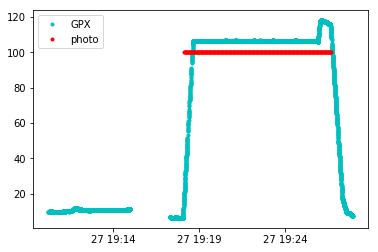

In [11]:
# Export CSV for original photo EXIF times
imgcsvoutfile = os.path.join(homedir, flight+'_imgtmp.csv')
imgdf.to_csv(imgcsvoutfile, index=False)
print ("Exported photo CSV file as:", imgcsvoutfile,"\n")
            
# print first and last image name and times
print("First file: {}, time: {}".format(imgdf.orig_name.iloc[0],imgdf.time_utc.iloc[0]))
print("Last file: {}, time: {}".format(imgdf.orig_name.iloc[-1],imgdf.time_utc.iloc[-1]),"\n")
# print first and last times in .gpx file
print("GPX data: {} from {} to {}".format(logfile, gpxdf.datetime_utc.iloc[0],gpxdf.datetime_utc.iloc[-1]))

#%% Plot times of image vs GPX data
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(gpxdf.datetime_utc, gpxdf.ele,'.c', label='GPX')
ax.plot(imgdf.time_utc, np.tile(gpxdf.ele.max(), imgdf.shape[0]),'.r', label='photo')
ax.legend()
#fig.clear()

### Image Rename

In [19]:
#TODO don't run if the names have already been changed...
rename_photos = True

if not os.path.exists(imgoutdir):
    shutil.copytree(imagefolder, imgoutdir)
for idx, row in imgdf.iterrows():
    img = row.orig_name
    namestr = "{}_{}_{}_{}".format(survey_id, fc_id, row.time_iso, img) # ->
    if rename_photos:
        os.rename(os.path.join(imagefolder, img), os.path.join(imgoutdir, namestr))
    imgdf.loc[idx, 'new_name'] = namestr

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/stor/Projects/UAS_SfM/EROS_plumisland_test/images/f6/P0027219.JPG' -> '/Volumes/stor/Projects/UAS_SfM/EROS_plumisland_test/images/f6_new/2018015FA_r01_20180227T191807Z_P0027219.JPG'

### EXIF GeoTag & add USGS EXIF meta to Images

In [21]:
# Run the ExifTool command to geotag images with a GPX file
# I needed to hard code the location of exiftools - this might be different depending on ExifTools install
#    if needed, you can always run it at the command line flight-by-flight

## command line syntax:
## exiftool -geosync=-0:0:0 -geotag ./tlogs/f6.gpx ./images/f6

#os.system("/usr/local/bin/exiftool -geosync=-0:0:0 -geotag " + homedir + "/tlogs/f11.gpx " + homedir + "/images/f11")
# os.system("/usr/local/bin/exiftool -geosync=-0:0:0 -geotag " + logfile + " " + imagefolder)  

# Write to EXIF
cmd = """exiftool -geosync=-0:0:0 -geotag {} {}""".format(logfile, imgoutdir)
subprocess.check_call(cmd, shell=True)

# Run ExifTool again to update other USGS specific meta tags
write_WHSC_exiftags(imgoutdir, credit, comment, keywords)

True